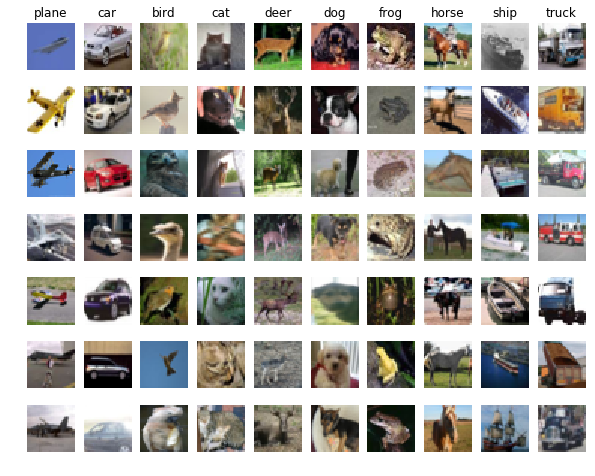

(48000, 32, 32, 3)
Training data shape:  (48000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)
[ 130.64297917  135.92841667  132.4100625   130.0744375   135.3130625
  131.70479167  131.0373125   136.18741667  132.48804167  131.65420833]


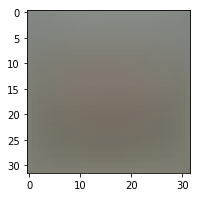

(48000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [1]:
import time
import random
import math
import numpy as np
from dl4cv.model_savers import save_softmax_classifier
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

from dl4cv.data_utils import load_CIFAR10
# Load the raw CIFAR-10 data
cifar10_dir = 'datasets/'
X, y = load_CIFAR10(cifar10_dir)

# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y_hat, cls in enumerate(classes):
    idxs = np.flatnonzero(y == y_hat)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y_hat + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the data set;
# we can use this for development so our code runs faster.
num_training = 48000
num_validation = 1000
num_test = 1000
num_dev = 500

assert (num_training + num_validation + num_test) == 50000, 'You have not provided a valid data split.'

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X[mask]
y_train = y[mask]

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X[mask]
y_val = y[mask]

# We use a small subset of the training set as our test set.
mask = range(num_training + num_validation, num_training + num_validation + num_test)
X_test = X[mask]
y_test = y[mask]

# We will also make a development set, which is a small subset of
# the training set. This way the development cycle is faster.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# Preprocessing: reshape the image data into rows
print(X_train.shape)
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
#3072=32*32*3
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(3,3))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our classifier
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)


In [2]:

from dl4cv.classifiers.softmax import softmax_loss_naive

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)
# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))
#print('Gradient: ', grad)


loss: 0.004529
sanity check: 2.302585


In [3]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# We use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from dl4cv.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, num_checks=3)

# Do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, num_checks=3)

# Again, running this might take a while!

numerical: 0.003225 analytic: 0.003225, relative error: 2.714006e-09
numerical: 0.054908 analytic: 0.054908, relative error: 5.823397e-10
numerical: 0.017879 analytic: 0.017879, relative error: 1.294975e-08
numerical: -0.011630 analytic: -0.011630, relative error: 1.277075e-08
numerical: 0.022780 analytic: 0.022780, relative error: 9.631089e-09
numerical: -0.009078 analytic: -0.009078, relative error: 6.607739e-09


In [4]:
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from dl4cv.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# We use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 4.529167e-03 computed in 0.180073s
vectorized loss: 4.529167e-03 computed in 0.175106s
Loss difference: 0.000000
Gradient difference: 0.000000


In [16]:
from dl4cv.classifiers import Softmax

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1
best_softmax = None
all_classifiers = []
learning_rates = [1e-8, 5e-8, 1e-7, 5e-7, 1e-6, 5e-6, 1e-5]
regularization_strengths = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4]

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a classifier on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the Softmax object that achieves this    #
# accuracy in best_softmax.                                                    #
#                      
#
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the classifiers don't take much time to train;       # 
# once you are confident that your validation code works, you should rerun     #
# the validation code with a larger value for num_iters.                       #
################################################################################

best_comb = {}
for lr in learning_rates:
    for reg in regularization_strengths:
        softmax = Softmax()
        loss_hist = softmax.train(X_train, y_train, learning_rate=lr, reg=reg,
                      num_iters=1200, verbose=True)
        y_train_pred = softmax.predict(X_train)
        training_accuracy = np.mean(y_train == y_train_pred)
        print('training accuracy: %f' % training_accuracy, )
        y_val_pred = softmax.predict(X_val)
        validation_accuracy = np.mean(y_val == y_val_pred)
        print('validation accuracy: %f' % validation_accuracy, )
        ke = str(lr)+"_"+str(reg)
        results.update({(lr, reg):(training_accuracy, validation_accuracy)})
        if validation_accuracy > best_val:
            best_val = validation_accuracy
            best_comb = {"training accuracy": training_accuracy, "validation_accuracy":validation_accuracy, "softmax_obj":softmax, "lr": lr, "reg": reg}

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for (lr, reg) in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
          lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during validation: %f' % best_val)
print(best_comb)

iteration 0 / 1200: loss 0.053219
iteration 100 / 1200: loss 0.009043
iteration 200 / 1200: loss 0.034032
iteration 300 / 1200: loss 0.014180
iteration 400 / 1200: loss 0.000491
iteration 500 / 1200: loss 0.035650
iteration 600 / 1200: loss 0.004776
iteration 700 / 1200: loss 0.019483
iteration 800 / 1200: loss 0.026288
iteration 900 / 1200: loss 0.033147
iteration 1000 / 1200: loss 0.014171
iteration 1100 / 1200: loss 0.023752
training accuracy: 0.101708
validation accuracy: 0.102000
iteration 0 / 1200: loss 0.035577
iteration 100 / 1200: loss 0.007757
iteration 200 / 1200: loss 0.016909
iteration 300 / 1200: loss 0.012507
iteration 400 / 1200: loss 0.028316
iteration 500 / 1200: loss 0.012394
iteration 600 / 1200: loss 0.031342
iteration 700 / 1200: loss 0.049482
iteration 800 / 1200: loss 0.011917
iteration 900 / 1200: loss 0.000552
iteration 1000 / 1200: loss 0.007173
iteration 1100 / 1200: loss 0.027005
training accuracy: 0.108688
validation accuracy: 0.112000
iteration 0 / 1200: 

In [17]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from dl4cv.classifiers import Softmax
softmax = Softmax()
tic = time.time()
#optimized from hyperparams
blr = 1.000000e-05
breg = 1.000000e+02
loss_hist = softmax.train(X_train, y_train, learning_rate=blr, reg=breg,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))



iteration 0 / 1500: loss 1.579726
iteration 100 / 1500: loss 1.304532
iteration 200 / 1500: loss 1.066186
iteration 300 / 1500: loss 0.877850
iteration 400 / 1500: loss 0.708692
iteration 500 / 1500: loss 0.585660
iteration 600 / 1500: loss 0.473878
iteration 700 / 1500: loss 0.399194
iteration 800 / 1500: loss 0.354921
iteration 900 / 1500: loss 0.260126
iteration 1000 / 1500: loss 0.218198
iteration 1100 / 1500: loss 0.192615
iteration 1200 / 1500: loss 0.153348
iteration 1300 / 1500: loss 0.120340
iteration 1400 / 1500: loss 0.104791
That took 140.398102s


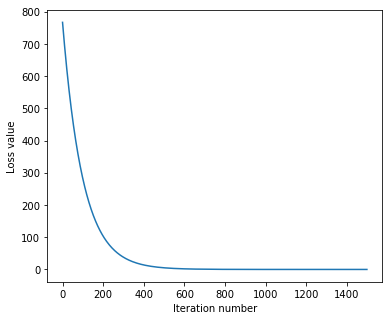

In [6]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.figure(figsize=(6,5))
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [18]:
# Write the LinearClassifier.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = softmax.predict(X_train)
#print(np.mean(y_train == y_train_pred))
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.280625
validation accuracy: 0.260000


In [ ]:
# Visualize the validation results
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')

plt.tight_layout()
plt.show()

In [ ]:
# if you want to take a look at the other classifiers assign them to best_softmax here
sorted_classifiers = sorted(all_classifiers, key=lambda x : x[1])
best_softmax = sorted_classifiers[-1][0]

In [13]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = softmax.predict(X_test)  #best_softmax
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.268000


In [ ]:
# Visualize the learned weights for each class
#best_softmax = sorted_classifiers[idx][0]
#softmax.W = softmax.W.transpose(1,0)
w = softmax.W[:-1,:] # strip out the bias   #best_softmax
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])
    plt.show()
  

In [20]:
from dl4cv.model_savers import save_softmax_classifier
from dl4cv.classifiers import Softmax

save_softmax_classifier(softmax)